In [4]:
import time
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from dops import *
warnings.filterwarnings('ignore')

In [5]:
with open('./Data/states_bpleq65.p','rb') as f:
    states = pickle.load(f)

In [6]:
patient_ids = list(states.keys())

In [8]:
pid = patient_ids[0]
df_clean = states[pid].loc[:,~states[pid].columns.isin(['Times','bicarbonate_ind', 'bun_ind','creatinine_ind',
                                                        'fio2_ind','glucose_ind','hct_ind','hr_ind','lactate_ind',
                                                        'magnesium_ind','meanbp_ind','platelets_ind','potassium_ind',
                                                        'sodium_ind','spo2_ind','spontaneousrr_ind','temp_ind',
                                                        'urine_ind','wbc_ind'])]

df_clean.insert(0,'ICU_ID',pid)
df_x_train = df_clean.loc[:,~df_clean.columns.isin(['sofa','oasis','saps'])]
df_y_train = df_clean[['sofa','oasis','saps']]

x_train = df_x_train.iloc[0]
y_train = df_y_train.iloc[0]


for pid in patient_ids[1:]:
    df_clean = states[pid].loc[:,~states[pid].columns.isin(['Times','bicarbonate_ind', 'bun_ind','creatinine_ind',
                                                            'fio2_ind','glucose_ind','hct_ind','hr_ind','lactate_ind',
                                                            'magnesium_ind','meanbp_ind','platelets_ind','potassium_ind',
                                                            'sodium_ind','spo2_ind','spontaneousrr_ind','temp_ind',
                                                            'urine_ind','wbc_ind'])]
    
    df_clean.insert(0,'ICU_ID',pid)
    df_x_train = df_clean.loc[:,~df_clean.columns.isin(['sofa','oasis','saps'])]
    df_y_train = df_clean[['sofa','oasis','saps']]
    
    x_train = pd.concat([x_train,df_x_train.iloc[0]],axis=1)
    y_train = pd.concat([y_train,df_y_train.iloc[0]],axis=1)

In [9]:
x_train = x_train.T.reset_index(drop=True)
y_train = y_train.T.reset_index(drop=True)

In [10]:
x_train = x_train.drop(['ICU_ID'],axis=1)

In [11]:
##Multilevel Transformation
multilevel_header = ["age1","age2","age3","age4","age5","is_F",
                     "weight","surg_ICU","is_not_white","is_emergency","is_urgent",
                     "hrs_from_admit_to_icu","bicarbonate1","bicarbonate2","bun","creatinine",
                     "fio2","glucose","hct","hr1","hr2","hr3","hr4","lactate","magnesium","meanbp",
                     "platelets","potassium1","potassium2","sodium1","sodium2","spo2","spontaneousrr","temp","urine1","urine2","wbc"]

multilevel_df = pd.DataFrame(0,index=np.arange(len(x_train)),columns=multilevel_header)

for i,row in x_train.iterrows():
    if 40 < row['age'] <= 59:
        multilevel_df.iloc[i]['age1'] = 1
    elif 60 < row['age'] <= 69:
        multilevel_df.iloc[i]['age2'] = 1
    elif 70 < row['age'] <= 74:
        multilevel_df.iloc[i]['age3'] = 1
    elif 75 < row['age'] <= 79:
        multilevel_df.iloc[i]['age4'] = 1
    elif row['age'] > 80:
        multilevel_df.iloc[i]['age5'] = 1 
    
    multilevel_df.iloc[i]['is_F'] = 1 if row['is_F'] == 1 else 0
    multilevel_df.iloc[i]['weight'] = 1 if row['weight'] >= 75 else 0
    multilevel_df.iloc[i]['hrs_from_admit_to_icu'] = 1 if row['hrs_from_admit_to_icu'] >= 1 else 0
    
    if 15 <= row['bicarbonate'] <= 19:
        multilevel_df.iloc[i]['bicarbonate1'] = 1
    elif row['bicarbonate'] < 15:
        multilevel_df.iloc[i]['bicarbonate2'] = 1
    
    multilevel_df.iloc[i]['bun'] = 0 if 7 <= row['bun'] <= 12 else 1
    multilevel_df.iloc[i]['creatinine'] = 0 if 0.5 <= row['creatinine'] <= 1.2 else 1
    multilevel_df.iloc[i]['fio2'] = 1 if row['fio2'] >= 0.5 else 0
    multilevel_df.iloc[i]['glucose'] = 1 if row['glucose'] >= 125 else 0
    multilevel_df.iloc[i]['hct'] = 0 if 37 <= row['hct'] <= 52 else 1
    
    if 40 <= row['hr'] <= 69:
        multilevel_df.iloc[i]['hr1'] = 1
    elif 120 <= row['hr'] <= 159:
        multilevel_df.iloc[i]['hr2'] = 1
    elif row['hr'] >= 160:
        multilevel_df.iloc[i]['hr3'] = 1
    elif row['hr'] < 40:
        multilevel_df.iloc[i]['hr4'] = 1
    
    multilevel_df.iloc[i]['lactate'] = 1 if row['lactate'] >= 2 else 0
    multilevel_df.iloc[i]['magnesium'] = 0 if 1.5 <= row['magnesium'] <= 2.5 else 1
    multilevel_df.iloc[i]['meanbp'] = 1 if row['meanbp'] <= 65 else 0
    multilevel_df.iloc[i]['platelets'] = 0 if 140 <= row['platelets'] <= 450 else 1
    
    if row['potassium'] >= 5:
        multilevel_df.iloc[i]['potassium1'] = 1
    elif row['potassium'] < 3:
        multilevel_df.iloc[i]['potassium2'] = 1
        
    if row['sodium'] >= 145:
        multilevel_df.iloc[i]['sodium1'] = 1
    elif row['sodium'] < 125:
        multilevel_df.iloc[i]['sodium2'] = 1
    
    multilevel_df.iloc[i]['spo2'] = 1 if row['spo2'] <= 95 else 0
    multilevel_df.iloc[i]['spontaneousrr'] = 0 if 12 <= row['spontaneousrr'] <= 25 else 1
    multilevel_df.iloc[i]['temp'] = 1 if row['temp'] >= 39 else 0
    
    if 50 <= row['urine'] <= 99:
        multilevel_df.iloc[i]['urine1'] = 1
    elif row['urine'] < 50:
        multilevel_df.iloc[i]['urine2'] = 1
        
    multilevel_df.iloc[i]['wbc'] = 0 if 4.3 <= row['wbc'] <= 10.8 else 1


In [12]:
## Binary Transformation
##1's indicate the patient's feature is in bad condition, 0's means feature values in normal

bilevel_df = x_train.copy()

bilevel_df['age'] = np.where(bilevel_df['age']>=60,1,0)
bilevel_df['weight'] = np.where(bilevel_df['weight']>=75,1,0)
bilevel_df['hrs_from_admit_to_icu'] = np.where(bilevel_df['hrs_from_admit_to_icu']>=1,1,0)
bilevel_df['bicarbonate'] = np.where(bilevel_df['bicarbonate']<=20,1,0)
bilevel_df['bun'] = np.where(np.logical_and(bilevel_df['bun']>=7,bilevel_df['bun']<=20),0,1)
bilevel_df['creatinine'] = np.where(np.logical_and(bilevel_df['creatinine']>=0.5,bilevel_df['creatinine']<=1.2),0,1)
bilevel_df['fio2'] = np.where(bilevel_df['fio2']>=0.5,1,0)
bilevel_df['glucose'] = np.where(bilevel_df['glucose']>=125,1,0)
bilevel_df['hct'] = np.where(np.logical_and(bilevel_df['hct']>=37,bilevel_df['hct']<=52),0,1)
bilevel_df['hr'] = np.where(np.logical_and(bilevel_df['hr']>=70,bilevel_df['hr']<=119),0,1)
bilevel_df['lactate'] = np.where(bilevel_df['lactate']>=2,1,0)
bilevel_df['magnesium'] = np.where(np.logical_and(bilevel_df['magnesium']>=1.5,bilevel_df['magnesium']<=2.5),0,1)
bilevel_df['meanbp'] = np.where(bilevel_df['meanbp']<=65,1,0)
bilevel_df['platelets'] = np.where(np.logical_and(bilevel_df['platelets']>=140,bilevel_df['platelets']<=450),0,1)
bilevel_df['potassium'] = np.where(np.logical_and(bilevel_df['potassium']>=3,bilevel_df['potassium']<=4.9),0,1)
bilevel_df['sodium'] = np.where(np.logical_and(bilevel_df['sodium']>=125,bilevel_df['potassium']<=144),0,1)
bilevel_df['spo2'] = np.where(bilevel_df['spo2']<=95,1,0)
bilevel_df['spontaneousrr'] = np.where(np.logical_and(bilevel_df['spontaneousrr']>=12,bilevel_df['spontaneousrr']<=25),0,1)
bilevel_df['temp'] = np.where(bilevel_df['temp']>=39,1,0)
bilevel_df['urine'] = np.where(bilevel_df['urine']<=100,1,0)
bilevel_df['wbc'] = np.where(np.logical_and(bilevel_df['wbc']>=4.3,bilevel_df['wbc']<=10.8),0,1)


In [13]:
manual_bilevel_coverage = np.array([[1,0,0,1,0,0,0,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1],
[0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1],
[1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,1,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0],
[0,0,0,1,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0],
[0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0],
[1,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0],
[1,1,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0],
[1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0],
[1,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0],
[1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1],
[0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0],
[1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0],
[1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0],
[1,0,1,0,0,1,1,0,1,1,1,1,1,0,1,1,1,1,0,0,1,1,1,1,1,1],
[1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1],
[1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0],
[1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0],
[1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0],
[1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,1,1,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1],
[1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0],
[1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,1]])

In [14]:
manual_multilevel_coverage = np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                                     [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                                     [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                                     [0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,1,1,1,0,0,0,0,1,1,1,1,1,0,1,0,1,1,0,1,0,1],
                                     [0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,1,1,1,1,0,0,0,0,1,1,1,1,0,1,0,1,1,1,0,0,1,1],
                                     [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,1,1,1,0,0,0,0,1,1,1,1,1,0,1,0,1,0,0,1,0,1],
                                     [0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0],
                                     [0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0],
                                     [0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,0],
                                     [0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
                                     [0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1],
                                     [0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0],
                                     [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0],
                                     [0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,1,1,0,1,0,1,0,0,1,0,1,0,0],
                                     [0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,1,1,0,0,1,0,1,0,1,0,0,1,0],
                                     [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0],
                                     [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,1,0,0,1,1,0,1,0,1,1,1,1,0,1,0,0,0,1,1,1,0,0,0,1,0,1,1,1,1,0,1],
                                     [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1],
                                     [0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0],
                                     [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0],
                                     [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1],
                                     [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0],
                                     [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0],
                                     [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1]])

In [15]:
multilevel_x_train = multilevel_df.values
bilevel_x_train = bilevel_df.values

len(multilevel_df) == len(bilevel_df)

True

In [16]:
harder_measure = ['lactate','platelets','bun','hct','creatinine','magnesium','potassium','bicarbonate','sodium']
a = [bilevel_df.columns.get_loc(col) for col in harder_measure]
a

[15, 18, 9, 13, 10, 16, 19, 8, 20]

In [17]:
harder_measure = ['lactate','platelets','bun','hct','creatinine','magnesium','potassium1','potassium2',
                  'bicarbonate1','bicarbonate2','sodium1','sodium2']

b = [multilevel_df.columns.get_loc(col) for col in harder_measure]
b


[23, 26, 14, 18, 15, 24, 27, 28, 12, 13, 29, 30]

In [18]:
bilevel_mti = {
    'lactate':[15],
    'platelets':[18],
    'bun':[9],
    'hct':[13],
    'creatinine':[10],
    'magnesium':[16],
    'potassium':[19],
    'bicarbonate':[8],
    'sodium':[20]
}

multilevel_mti = {
    'lactate':[23],
    'platelets':[26],
    'bun':[14],
    'hct':[18],
    'creatinine':[15],
    'magnesium':[24],
    'potassium':[27,28],
    'bicarbonate':[12,13],
    'sodium':[29,30],
}

Starting DOPS when dropping ['lactate', 'platelets', 'bun', 'hct', 'creatinine', 'magnesium', 'potassium', 'bicarbonate', 'sodium']
Iter 40, theta: [0.54458508 0.48998693 0.4871324  0.52430185 0.46473091 0.53540863
 0.56606818 0.41673494 0.54942449 0.56166485 0.56166485 0.56166485
 0.48548598 0.56023204 0.47244879 0.56166485 0.54942449 0.45560331
 0.55496005 0.54579001 0.54942449 0.47890575 0.50777914 0.54433286
 0.54965111 0.45717657], gradient: [-0.00857403 -0.00795429 -0.00747336 -0.00855118 -0.00692538 -0.00876841
 -0.0092174  -0.00571408 -0.00893297 -0.00913198 -0.00913198 -0.00913198
 -0.00738804 -0.00910869 -0.00746815 -0.00913198 -0.00893297 -0.00704232
 -0.00901606 -0.00886696 -0.00893297 -0.00725146 -0.0080535  -0.00871359
 -0.0088972  -0.00718838]
Iter 80, theta: [0.79248748 0.68828708 0.66991673 0.76517685 0.6659627  0.77180431
 0.81456849 0.5470769  0.79025655 0.8078623  0.8078623  0.8078623
 0.67025998 0.80580143 0.65565319 0.8078623  0.79025655 0.63616136
 0.79803217 0.7

Iter 120, theta: [0.90856502 0.9946335  0.94459988 0.87227027 0.78682717 0.74706997
 0.70325943 0.91577929 0.91577929 0.91577929 0.91577929 0.60923191
 0.81143841 0.82960665 0.8624082  0.90625661 0.91577929 0.72031999
 0.86268388 0.76498699 0.78784254 0.91577929 0.91577929 0.91577929
 0.80524442 0.67649702 0.76732417 0.91577929 0.70654855 0.91577929
 0.70654855 0.72779356 0.78927008 0.90892652 0.91822301 0.87298504
 0.91577929], gradient: [-0.00166903 -0.00190916 -0.00187342 -0.00166442 -0.00146339 -0.00137603
 -0.00117926 -0.0017546  -0.0017546  -0.0017546  -0.0017546  -0.00077544
 -0.00155045 -0.00161179 -0.00165071 -0.00173635 -0.0017546  -0.00114777
 -0.00165205 -0.00125027 -0.00130912 -0.0017546  -0.0017546  -0.0017546
 -0.00153777 -0.00108843 -0.00143846 -0.0017546  -0.00130409 -0.0017546
 -0.00130409 -0.00116416 -0.00145653 -0.00174147 -0.00170268 -0.0016971
 -0.0017546 ]
Iter 160, theta: [0.95590258 1.04610423 0.99510699 0.91714281 0.82393935 0.78205133
 0.73716856 0.9630831  0

Iter 80, theta: [0.75254008 0.74535062 0.69247408 0.70900281 0.74485058 0.79011191
 0.80542851 0.50496473 0.74799332 0.80511447 0.8078623  0.8078623
 0.69483606 0.80199036 0.68142953 0.8078623  0.74799332 0.65096057
 0.79221593 0.74532718 0.74799332 0.65487024 0.64036275 0.78765921
 0.82486773 0.74794376], gradient: [-0.00380364 -0.00400505 -0.00321582 -0.00231673 -0.00320782 -0.00401482
 -0.00399081 -0.00143562 -0.00367718 -0.00398925 -0.00400287 -0.00400287
 -0.00289042 -0.00397167 -0.00314712 -0.00400287 -0.00367718 -0.00259698
 -0.00392324 -0.00366186 -0.00367718 -0.00252227 -0.00258561 -0.00371515
 -0.00464251 -0.0032964 ]
Iter 120, theta: [0.855086   0.85332648 0.77917234 0.77146157 0.831333   0.89835103
 0.91302039 0.54366882 0.84712974 0.9126644  0.91577929 0.91577929
 0.77276157 0.90906616 0.7662755  0.91577929 0.84712974 0.72097486
 0.89798603 0.84405065 0.84712974 0.72287055 0.71007054 0.88781932
 0.95002935 0.83681446], gradient: [-0.00166727 -0.00175556 -0.00140961 -0.0010

Iter 160, theta: [1.02881357 0.94467285 0.98057974 1.01456332 0.79942137 0.80763537
 0.82071037 0.9630831  0.9630831  0.9630831  0.9630831  0.74721674
 0.88107083 0.7502047  0.92580218 0.9630831  0.9630831  0.81657611
 0.93247014 0.90259092 0.83589338 0.9630831  0.9630831  0.9630831
 0.85833546 0.86981138 0.82652306 0.9630831  0.6416736  0.9630831
 0.6416736  0.78610231 0.80635264 0.93642449 1.0267734  0.91813972
 0.9630831 ], gradient: [-0.00081796 -0.00071786 -0.00069563 -0.0008729  -0.00076673 -0.00099344
 -0.00027715 -0.0007691  -0.0007691  -0.0007691  -0.0007691  -0.00072054
 -0.00069906 -0.00058439 -0.00073796 -0.0007691  -0.0007691  -0.00058245
 -0.00074432 -0.00041422 -0.00047914 -0.0007691  -0.0007691  -0.0007691
 -0.00068023 -0.00017238 -0.00058426 -0.0007691  -0.00066646 -0.0007691
 -0.00066646 -0.00083264 -0.00047099 -0.00074747 -0.00098954 -0.00059694
 -0.0007691 ]
Iter 200, theta: [1.04971376 0.96402635 1.00622188 1.03809666 0.81435634 0.82408217
 0.83163062 0.98381803 0.

Iter 160, theta: [0.84540862 0.78245064 0.83577036 0.74526173 0.92708783 0.95391683
 0.94554796 0.72076124 0.88104818 0.9630831  0.9630831  0.9630831
 0.82181153 0.95816941 0.7712384  0.9630831  0.88104818 0.81084229
 0.92591085 0.88104818 0.88104818 0.72817167 0.80447377 0.92463901
 0.95818694 0.88061928], gradient: [-0.00063319 -0.00011456 -0.00056724 -0.00105433 -0.00044646 -0.00068067
 -0.00073456 -0.00094118 -0.00070257 -0.0007691  -0.0007691  -0.0007691
 -0.00064597 -0.00076518 -0.0001715  -0.0007691  -0.00070257 -0.00036632
 -0.00073874 -0.00070257 -0.00070257 -0.00048513 -0.00033703 -0.00071968
 -0.00113532 -0.00093523]
Iter 200, theta: [0.85593701 0.80013435 0.85703753 0.75823127 0.94120291 0.96658524
 0.9653515  0.73808248 0.89998945 0.98381803 0.98381803 0.98381803
 0.83268456 0.97879855 0.78448288 0.98381803 0.89998945 0.82872988
 0.94582716 0.89998945 0.89998945 0.74125063 0.82039436 0.94404154
 0.98135143 0.90436367], gradient: [ 1.13213242e-05 -5.96488422e-04 -5.49347654

Iter 200, theta: [0.98672141 0.99798436 1.07187428 0.99106659 0.74376828 0.83765962
 0.79655583 0.98381803 0.98381803 0.98381803 0.98381803 0.73050465
 0.86131411 0.82094458 0.90200893 0.98381803 0.98381803 0.80623401
 0.9246577  0.83734343 0.88597112 0.98381803 0.98381803 0.98381803
 0.83071373 0.8257271  0.78841658 0.98381803 0.65093208 0.98381803
 0.65093208 0.80885777 0.81309917 0.96876647 0.97066873 0.98622781
 0.98381803], gradient: [-3.24246548e-04 -2.94088248e-04 -3.89733054e-04 -3.43404092e-04
 -2.86444097e-04 -5.18696639e-04 -2.31468489e-04 -3.37124435e-04
 -3.37124435e-04 -3.37124435e-04 -3.37124435e-04 -2.28216669e-04
 -2.94709000e-04 -2.27898411e-04 -3.05369454e-04 -3.37124435e-04
 -3.37124435e-04 -2.18481966e-04 -3.16560609e-04 -1.65215485e-05
 -3.02575435e-04 -3.37124435e-04 -3.37124435e-04 -3.37124435e-04
 -2.82651504e-04 -2.64939710e-04 -2.63898820e-04 -3.37124435e-04
 -2.04516878e-04 -3.37124435e-04 -2.04516878e-04 -2.71523891e-04
 -2.57382089e-04 -3.31821032e-04 -3.2

Iter 200, theta: [0.95224429 0.84536546 0.84274113 0.72719137 0.74697268 0.97267164
 0.97915858 0.58104717 0.93672473 0.98381803 0.98381803 0.98381803
 0.77377455 0.97411189 0.70729949 0.98381803 0.93672473 0.7219291
 0.96318058 0.93003209 0.93672473 0.67721271 0.68904457 0.96926629
 0.9866312  0.78661547], gradient: [-2.84207944e-04 -1.50143992e-04 -2.85924986e-04 -3.36401245e-04
 -3.19858396e-04 -3.32613810e-04 -3.39713994e-04 -3.04478928e-04
 -3.20404227e-04 -3.37124435e-04 -3.37124435e-04 -3.37124435e-04
 -2.33498566e-04 -3.33652745e-04 -5.36102717e-05 -3.37124435e-04
 -3.20404227e-04 -3.96704807e-04 -3.29906918e-04 -3.18110863e-04
 -3.20404227e-04 -1.60055673e-05 -2.19802137e-04 -3.28494160e-04
 -5.04906011e-04 -2.63498107e-05]
Iter 40, theta: [0.54723038 0.46213582 0.50133571 0.48828965 0.50077594 0.55744405
 0.56941572 0.4057736  0.56166485 0.56166485 0.56166485 0.56166485
 0.46495071 0.56166485 0.47402469 0.56166485 0.56166485 0.45617933
 0.56166485 0.56166485 0.56166485 0.4663

Iter 40, theta: [0.51698313 0.56252862 0.55705408 0.55075143 0.58518018 0.54172141
 0.47714399 0.56166485 0.56166485 0.56166485 0.56166485 0.44630755
 0.50437252 0.52286557 0.56166485 0.56166485 0.56166485 0.4996618
 0.56166485 0.54400831 0.47840208 0.56166485 0.56166485 0.56166485
 0.56166485 0.49056363 0.56166485 0.51540523 0.56139194 0.53776255
 0.53665106 0.48211428 0.45714888 0.54407895 0.58006453 0.54258137
 0.56166485], gradient: [-0.00791169 -0.0088906  -0.00888352 -0.00948825 -0.0094742  -0.00777728
 -0.00751003 -0.00913198 -0.00913198 -0.00913198 -0.00913198 -0.00544824
 -0.00733116 -0.00826796 -0.00913198 -0.00913198 -0.00913198 -0.00809034
 -0.00913198 -0.00808428 -0.00751048 -0.00913198 -0.00913198 -0.00913198
 -0.00913198 -0.00698143 -0.00913198 -0.00851855 -0.00912754 -0.00881909
 -0.00836747 -0.0070812  -0.0066575  -0.00871888 -0.00921432 -0.00871465
 -0.00913198]
Iter 80, theta: [0.70558867 0.8192397  0.79655293 0.80655372 0.8482756  0.75185754
 0.6796138  0.8078623  0

Iter 80, theta: [0.81613217 0.7359578  0.66466069 0.65084599 0.69556938 0.81546104
 0.80609584 0.58995201 0.8078623  0.8078623  0.8078623  0.8078623
 0.67614396 0.8078623  0.67756895 0.8078623  0.8078623  0.6696888
 0.8078623  0.8078623  0.8078623  0.64785713 0.64935892 0.75871484
 0.84059107 0.67881148], gradient: [-0.00425777 -0.00360786 -0.00306607 -0.0027971  -0.00316669 -0.00404601
 -0.00399412 -0.002156   -0.00400287 -0.00400287 -0.00400287 -0.00400287
 -0.00299842 -0.00400287 -0.00329216 -0.00400287 -0.00400287 -0.00307722
 -0.00400287 -0.00400287 -0.00400287 -0.00247267 -0.00259424 -0.00345769
 -0.00423109 -0.00318428]
Iter 120, theta: [0.92220886 0.82451285 0.74857096 0.71754308 0.7884062  0.92454115
 0.91377686 0.64807771 0.91577929 0.91577929 0.91577929 0.91577929
 0.75698105 0.91577929 0.76757479 0.91577929 0.91577929 0.75265048
 0.91577929 0.91577929 0.91577929 0.71452004 0.72676254 0.86064652
 0.94594823 0.76465941], gradient: [-0.00162267 -0.00133779 -0.00131794 -0.00098

Iter 120, theta: [0.82218797 0.86490055 0.90105757 0.92488171 0.99929876 0.80629624
 0.73202069 0.91577929 0.91577929 0.91577929 0.91577929 0.61079976
 0.83781122 0.87679047 0.91577929 0.91577929 0.91577929 0.8427723
 0.91577929 0.84422403 0.832086   0.91577929 0.91577929 0.91577929
 0.91577929 0.71992686 0.91577929 0.86413252 0.92204225 0.86282717
 0.9169928  0.66455373 0.74977489 0.86773202 0.93142815 0.92521124
 0.91577929], gradient: [-0.00159311 -0.00176619 -0.00132807 -0.0016858  -0.0020678  -0.0010663
 -0.00095812 -0.0017546  -0.0017546  -0.0017546  -0.0017546  -0.00089365
 -0.0018313  -0.00180156 -0.0017546  -0.0017546  -0.0017546  -0.00124217
 -0.0017546  -0.00145608 -0.00159912 -0.0017546  -0.0017546  -0.0017546
 -0.0017546  -0.00122935 -0.0017546  -0.00251036 -0.00156085 -0.00125376
 -0.00213645 -0.00095156 -0.00121661 -0.00159396 -0.00136462 -0.00193012
 -0.0017546 ]
Iter 160, theta: [0.86409702 0.89834402 0.94687799 0.97137165 1.05504656 0.84817535
 0.75866291 0.9630831  0

Iter 200, theta: [0.86246357 0.92555219 0.79726081 0.81335488 0.82382987 1.04382435
 0.96954222 0.67969406 0.98381803 0.98381803 0.98381803 0.98381803
 0.8000595  0.98381803 0.70224964 0.98381803 0.98381803 0.70810116
 0.98381803 0.98381803 0.98381803 0.75410236 0.72724048 0.93837205
 0.97164195 0.77820679], gradient: [-3.99861981e-04  1.67399613e-04 -5.08050430e-04 -4.97202627e-04
 -3.70316062e-05 -3.95402934e-04 -3.22745691e-04 -1.98307689e-04
 -3.37124435e-04 -3.37124435e-04 -3.37124435e-04 -3.37124435e-04
 -2.69047116e-04 -3.37124435e-04 -2.55813153e-04 -3.37124435e-04
 -3.37124435e-04  1.27269495e-04 -3.37124435e-04 -3.37124435e-04
 -3.37124435e-04  6.82565063e-05 -4.83267438e-04 -5.04437168e-04
 -3.05827543e-04 -3.03697288e-04]
Iter 40, theta: [0.59864878 0.5844351  0.57765733 0.5692835  0.4453399  0.50550504
 0.4999901  0.56166485 0.56166485 0.56166485 0.56166485 0.41830539
 0.50568315 0.50901027 0.52968525 0.56166485 0.56166485 0.48020954
 0.53715464 0.51536159 0.523965   0.561

Iter 200, theta: [1.01836178 0.84234888 0.97799476 1.00613877 1.00293247 0.87981689
 0.87486806 0.98381803 0.98381803 0.98381803 0.98381803 0.73782237
 0.90989934 0.90239721 0.98381803 0.98381803 0.98381803 0.77400017
 0.98381803 0.82357339 0.88045803 0.98381803 0.98381803 0.98381803
 0.98381803 0.77730303 0.98381803 0.87280947 0.97524806 0.9153626
 0.88251996 0.76318607 0.76783925 0.95045635 0.97558066 0.95841402
 0.98381803], gradient: [-6.18637265e-04 -2.55567779e-04 -3.42026841e-04 -6.74846891e-05
 -3.72512914e-04 -5.67247581e-05 -6.45396624e-04 -3.37124435e-04
 -3.37124435e-04 -3.37124435e-04 -3.37124435e-04 -2.97567378e-04
 -6.36848935e-04 -2.84795175e-04 -3.37124435e-04 -3.37124435e-04
 -3.37124435e-04 -2.37464032e-04 -3.37124435e-04 -1.69588443e-04
 -3.44361143e-04 -3.37124435e-04 -3.37124435e-04 -3.37124435e-04
 -3.37124435e-04 -2.93674684e-04 -3.37124435e-04 -3.33300666e-04
 -2.79459739e-04  1.02745017e-04 -2.87906802e-04 -1.41349536e-04
 -2.43327138e-04 -3.23542585e-04 -3.05

Iter 80, theta: [0.78514157 0.84462667 0.83784937 0.83339302 0.69644057 0.68700374
 0.71468559 0.8078623  0.8078623  0.8078623  0.8078623  0.56949422
 0.73466496 0.72891591 0.78250693 0.8078623  0.8078623  0.72655151
 0.75611767 0.77406993 0.71854405 0.8078623  0.8078623  0.8078623
 0.73686322 0.64817278 0.70653783 0.8078623  0.61705397 0.8078623
 0.61705397 0.64148303 0.64818888 0.78826527 0.79514014 0.81111735
 0.8078623 ], gradient: [-0.00391084 -0.00360998 -0.00414091 -0.00411633 -0.00409151 -0.00347421
 -0.00273149 -0.00400287 -0.00400287 -0.00400287 -0.00400287 -0.00207555
 -0.00363176 -0.0037738  -0.00387513 -0.00400287 -0.00400287 -0.00322984
 -0.00373805 -0.00343137 -0.00346854 -0.00400287 -0.00400287 -0.00400287
 -0.00364265 -0.00248684 -0.00344484 -0.00400287 -0.00345352 -0.00400287
 -0.00345352 -0.00197732 -0.00279425 -0.00385842 -0.0036332  -0.00443514
 -0.00400287]
Iter 120, theta: [0.89057754 0.94520115 0.94948804 0.94111909 0.80674721 0.7882774
 0.79157593 0.91577929 0.

Iter 40, theta: [0.52511135 0.49591835 0.4999554  0.47132876 0.57599705 0.57026429
 0.56166485 0.40971081 0.53099319 0.56166485 0.56166485 0.56166485
 0.49617913 0.55803037 0.42259074 0.56166485 0.53099319 0.48234525
 0.55086628 0.53099319 0.53099319 0.48660325 0.49091771 0.53691083
 0.52437723 0.47188019], gradient: [-0.00862509 -0.00715703 -0.00748392 -0.0070847  -0.00903535 -0.00950909
 -0.00913198 -0.00575716 -0.00861947 -0.00913198 -0.00913198 -0.00913198
 -0.00729332 -0.00906598 -0.00587148 -0.00913198 -0.00861947 -0.00709612
 -0.0089495  -0.00861947 -0.00861947 -0.00802782 -0.00794857 -0.00870877
 -0.00822939 -0.00686063]
Iter 80, theta: [0.76853473 0.6621125  0.69409194 0.65325483 0.82437042 0.82662857
 0.8078623  0.52861308 0.76337343 0.8078623  0.8078623  0.8078623
 0.68662453 0.80244833 0.53838508 0.8078623  0.76337343 0.64741829
 0.79214396 0.76337343 0.76337343 0.67257646 0.69699026 0.77169861
 0.74624076 0.65882471], gradient: [-0.00397894 -0.00241914 -0.00343941 -0.00286

Iter 120, theta: [0.90543669 0.94906432 0.93875026 0.89662305 0.72024311 0.79226088
 0.79266854 0.91577929 0.91577929 0.91577929 0.91577929 0.64268201
 0.83185001 0.83435673 0.84470012 0.9137027  0.91577929 0.74709206
 0.85529945 0.70258975 0.84377333 0.91577929 0.91577929 0.91577929
 0.82517269 0.73796589 0.78649006 0.91577929 0.65617395 0.91577929
 0.65617395 0.72488527 0.74131232 0.92312155 0.9799046  0.85308277
 0.91577929], gradient: [-0.00161424 -0.00168643 -0.0016953  -0.00187193 -0.0015295  -0.00138444
 -0.00136026 -0.0017546  -0.0017546  -0.0017546  -0.0017546  -0.0008221
 -0.00159053 -0.00133686 -0.00161353 -0.00175062 -0.0017546  -0.00143159
 -0.00163465 -0.00097236 -0.00172917 -0.0017546  -0.0017546  -0.0017546
 -0.00157611 -0.00113699 -0.00155545 -0.0017546  -0.00119311 -0.0017546
 -0.00119311 -0.00121278 -0.00129757 -0.00176867 -0.00200916 -0.00162228
 -0.0017546 ]
Iter 160, theta: [0.94895652 0.99453032 0.98445543 0.94477575 0.76379246 0.82812474
 0.82848712 0.9630831  0

Iter 80, theta: [0.75088237 0.71263989 0.64603924 0.70816469 0.73045297 0.80857503
 0.80099272 0.57182792 0.7596262  0.80167968 0.80580143 0.8078623
 0.66529759 0.79847388 0.58430819 0.8078623  0.7596262  0.71111205
 0.78237926 0.74267134 0.7596262  0.64229279 0.62395625 0.74689615
 0.80375833 0.61253063], gradient: [-0.00358915 -0.00321581 -0.00278758 -0.00265222 -0.00392332 -0.00438198
 -0.00396883 -0.00187272 -0.0037365  -0.00397223 -0.00399266 -0.00400287
 -0.00288425 -0.00395635 -0.00224102 -0.00400287 -0.0037365  -0.00308331
 -0.00387239 -0.00365038 -0.0037365  -0.00308445 -0.00257428 -0.00355275
 -0.00418656 -0.00274281]
Iter 120, theta: [0.84764558 0.79933781 0.72594762 0.77478547 0.82183127 0.9170743
 0.91763051 0.62719919 0.86036179 0.90877078 0.91344312 0.91577929
 0.73817378 0.90513673 0.6543644  0.91577929 0.86036179 0.78948217
 0.88677855 0.84108524 0.86036179 0.72544942 0.69335872 0.84267785
 0.91662768 0.68647643], gradient: [-0.00157325 -0.0014096  -0.00154799 -0.00126

Iter 160, theta: [0.95431924 1.01204035 0.96372236 1.03840439 0.75378907 0.76219345
 0.87206834 0.9630831  0.9630831  0.9630831  0.9630831  0.71640663
 0.90488109 0.80685028 0.9329461  0.95915215 0.9630831  0.84461975
 0.93359327 0.84995358 0.81262776 0.9630831  0.9630831  0.9630831
 0.90588971 0.81414504 0.865798   0.9630831  0.62072848 0.9630831
 0.62072848 0.74617433 0.77684219 0.93161262 0.97779844 0.96395509
 0.9630831 ], gradient: [-0.00082565 -0.00046031 -0.00075578 -0.00083023 -0.00056691 -0.0002005
 -0.00097975 -0.0007691  -0.0007691  -0.0007691  -0.0007691   0.00023551
 -0.00069702 -0.00103359 -0.00074402 -0.00076596 -0.0007691  -0.0006805
 -0.00074521 -0.00063518 -0.00027598 -0.0007691  -0.0007691  -0.0007691
 -0.00072207 -0.00059159 -0.00097271 -0.0007691  -0.00084468 -0.0007691
 -0.00084468 -0.00038846 -0.00013321 -0.00073029 -0.00121923 -0.00037537
 -0.0007691 ]
Iter 200, theta: [0.97478073 1.033367   0.98409824 1.06078741 0.76907304 0.77084345
 0.89136339 0.98381803 0.98

Iter 160, theta: [0.93828439 0.75052741 0.78668033 0.79831405 0.78413079 0.93233859
 0.94825524 0.73622445 0.8886527  0.9630831  0.9630831  0.9630831
 0.79997447 0.95654721 0.8205708  0.9630831  0.8886527  0.82069509
 0.9488257  0.88488671 0.8886527  0.78346293 0.80994639 0.94386081
 0.93807038 0.78621345], gradient: [-0.00015752 -0.00091713 -0.00085333  0.0004162  -0.00100599 -0.00078502
 -0.00073788 -0.00061194 -0.00070308 -0.0007691  -0.0007691  -0.0007691
 -0.00035214 -0.00076354 -0.00052807 -0.0007691  -0.00070308 -0.00078818
 -0.00075738 -0.0006965  -0.00070308 -0.00039413 -0.0004523  -0.0007444
 -0.00074811 -0.0008801 ]
Iter 200, theta: [0.95017308 0.76391069 0.80392763 0.8060778  0.79991326 0.9535026
 0.96814842 0.75641934 0.90760759 0.98381803 0.98381803 0.98381803
 0.81522652 0.97713227 0.83480401 0.98381803 0.90760759 0.83618234
 0.96924451 0.90366431 0.90760759 0.79985051 0.82790244 0.96392967
 0.95823932 0.80418239], gradient: [ 9.01583142e-05 -6.38313248e-04 -4.94009876e-

Iter 200, theta: [0.99670297 1.0676806  1.00041953 0.99851672 0.72808212 0.76381466
 0.75720446 0.98381803 0.98381803 0.98381803 0.98381803 0.71729385
 0.88916498 0.87659397 0.91141074 0.98381803 0.98381803 0.82934062
 0.92897242 0.92038937 0.88764643 0.98381803 0.98381803 0.98381803
 0.85391162 0.82104342 0.81150576 0.98381803 0.69864056 0.98381803
 0.69864056 0.73435081 0.81570631 0.97084053 1.08477662 0.9135961
 0.98381803], gradient: [-6.97409102e-04 -5.64497645e-04 -3.32408150e-04 -2.59039411e-04
  2.13495741e-04  2.31867563e-04 -7.03451873e-05 -3.37124435e-04
 -3.37124435e-04 -3.37124435e-04 -3.37124435e-04  1.84760106e-04
 -3.03815564e-04 -3.69354137e-04 -3.10595295e-04 -3.37124435e-04
 -3.37124435e-04 -5.60945754e-04 -3.17747748e-04 -1.75183637e-04
 -5.90093744e-04 -3.37124435e-04 -3.37124435e-04 -3.37124435e-04
 -2.90163635e-04 -1.58003984e-05 -2.60684418e-04 -3.37124435e-04
 -1.89041432e-05 -3.37124435e-04 -1.89041432e-05  2.87744883e-05
 -7.33685767e-04 -3.24042165e-04 -3.96

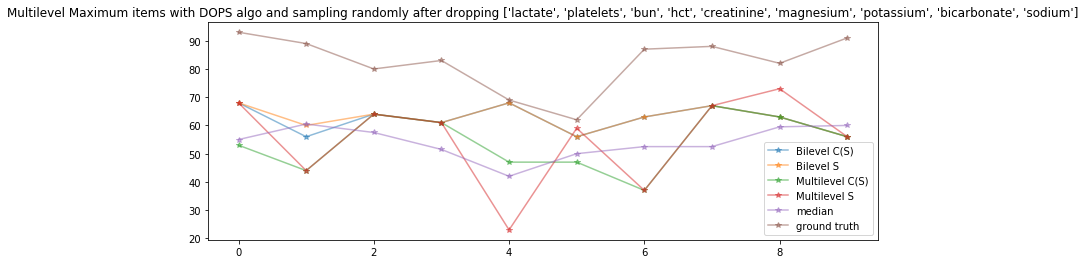

In [19]:
from itertools import combinations

harder_measure = ['lactate','platelets','bun','hct','creatinine','magnesium','potassium','bicarbonate','sodium']

# Randomly select 1000 items from the master
#for item in combinations(harder_measure,2):
for i in range(1):
    
    #measure = list(item)
    measure = harder_measure
    print("Starting DOPS when dropping " + str(measure))
    
    bi_cover,multi_cover = [],[]
    for m in measure:
        bi_cover.extend(bilevel_mti[m])
        multi_cover.extend(multilevel_mti[m])
            
    bi_preds = []
    bi_preds_cover_self = []
    multi_preds = []
    multi_preds_cover_self = []
    truths = []
    t1 = time.time()
    repeat = 10
    for i in range(repeat):
        start = time.time()
        np.random.seed(i)
        index = np.random.choice(len(multilevel_df), size=1000, replace=False)
        bi_x, multi_x, y = bilevel_df.iloc[index], multilevel_df.iloc[index], y_train.iloc[index]
        bi_x[measure] = 0.0
        multi_x[measure] = 0.0
        bi_x_train_dops = bi_x.values
        multi_x_train_dops = multi_x.values
        y_train_dops = y['saps'].values + y['oasis'].values + y['sofa'].values
        bi_X_train, bi_X_test,Y_train,Y_test = train_test_split(bi_x_train_dops,y_train_dops,test_size=0.02,random_state=i)
        multi_X_train, multi_X_test,Y_train,Y_test = train_test_split(multi_x_train_dops,y_train_dops,test_size=0.02,random_state=i)
        test_len = len(Y_test)
        bi_res1, bi_pred_theta, bi_max_item_index = dops(bi_X_train, Y_train, bi_X_test, manual_bilevel_coverage, test_len, 0.8, \
                                               np.zeros(26), batch_size=64, eta=1, iters=200, print_every=40,cover_indices=bi_cover)
        bi_res2, bi_pred_theta, bi_max_item_index = dops(bi_X_train, Y_train, bi_X_test, np.eye(len(manual_bilevel_coverage)), test_len, 0.8, \
                                               np.zeros(26), batch_size=64, eta=1, iters=200, print_every=40,cover_indices=bi_cover)
        
        multi_res1, multi_pred_theta, multi_max_item_index = dops(multi_X_train, Y_train, multi_X_test, manual_multilevel_coverage, test_len, 0.8, \
                                               np.zeros(37), batch_size=64, eta=1, iters=200, print_every=40,cover_indices=multi_cover)
        multi_res2, multi_pred_theta, multi_max_item_index = dops(multi_X_train, Y_train, multi_X_test, np.eye(len(manual_multilevel_coverage)), test_len, 0.8, \
                                               np.zeros(37), batch_size=64, eta=1, iters=200, print_every=40,cover_indices=multi_cover)
        
        bi_preds.append(bi_res1)
        bi_preds_cover_self.append(bi_res2)
        multi_preds.append(multi_res1)
        multi_preds_cover_self.append(multi_res2)
        truths.append(Y_test)
        end = time.time()
        print("One repetition takes {0} seconds".format(end-start))
    
    bi_pred = []
    bi_pred_cover_self = []
    multi_pred = []
    multi_pred_cover_self = []
    real = []
    rand = []
    for i in range(repeat):
        bi_pred.append(truths[i][np.argmax(bi_preds[i])])
        bi_pred_cover_self.append(truths[i][np.argmax(bi_preds_cover_self[i])])
        multi_pred.append(truths[i][np.argmax(multi_preds[i])])
        multi_pred_cover_self.append(truths[i][np.argmax(multi_preds_cover_self[i])])
        real.append(max(truths[i]))
        rand.append(np.median(truths[i]))
    t2 = time.time()
    print('Used time: %.2fs' % (t2-t1))

    plt.figure(figsize=(12,4))
    plt.plot(np.arange(0,repeat), bi_pred, '*-', alpha=0.5, label='Bilevel C(S)')
    plt.plot(np.arange(0,repeat), bi_pred_cover_self, '*-', alpha=0.5, label='Bilevel S')
    plt.plot(np.arange(0,repeat), multi_pred, '*-', alpha=0.5, label='Multilevel C(S)')
    plt.plot(np.arange(0,repeat), multi_pred_cover_self, '*-', alpha=0.5, label='Multilevel S')
    plt.plot(np.arange(0,repeat), rand, '*-', alpha=0.5, label='median')
    plt.plot(np.arange(0,repeat), real, '*-', alpha=0.5, label='ground truth')
    plt.legend()
    plt.title('Multilevel Maximum items with DOPS algo and sampling randomly after dropping ' + str(measure))
    plt.savefig("Multilevel results after dropping " + str(measure))

In [36]:
f_theta

<function dops.f_theta(theta, Siy, C, cover_indices)>

## Correlation

In [17]:
df_for_median = x_train.drop(['ICU_ID','is_F','is_not_white','is_emergency','is_urgent','surg_ICU'],axis=1)
median_dict = {}
for column in df_for_median.columns:
    #median_dict[column] = np.median(df_for_median[column].values)
    print(column,np.sum(df_for_median[column].values))
    #print(column)

age 9033
weight 7590
hrs_from_admit_to_icu 6193
bicarbonate 1937
bun 8054
creatinine 3953
fio2 13513
glucose 8093
hct 9578
hr 1308
lactate 3745
magnesium 197
meanbp 925
platelets 2586
potassium 1997
sodium 189
spo2 1303
spontaneousrr 1047
temp 98
urine 12526
wbc 5878


In [12]:
corr = x_train.corr()

In [13]:
corr

,age,is_F,weight,surg_ICU,is_not_white,is_emergency,is_urgent,hrs_from_admit_to_icu,bicarbonate,bun,...,magnesium,meanbp,platelets,potassium,sodium,spo2,spontaneousrr,temp,urine,wbc
age,1.000000,0.109126,-0.187078,-0.073283,-0.088023,0.057241,-0.003368,-0.044161,0.032949,0.136856,...,0.004366,-0.031428,-0.005977,0.047130,0.042847,-0.000135,0.015986,-0.032004,-0.017073,-0.008254
is_F,0.109126,1.000000,-0.259883,-0.065285,0.016332,0.033321,0.006128,-0.027789,-0.011121,-0.057222,...,-0.020733,-0.016264,0.088267,-0.113056,0.014797,-0.004342,0.005248,-0.034222,-0.000495,0.012152
weight,-0.187078,-0.259883,1.000000,0.009041,-0.009096,-0.047079,0.011968,0.005540,0.049432,0.017612,...,0.007538,0.011983,-0.039100,0.057337,-0.007765,-0.034777,0.010274,0.044819,0.015783,0.018920
surg_ICU,-0.073283,-0.065285,0.009041,1.000000,-0.019823,-0.284317,-0.025962,0.016883,0.075643,-0.203550,...,-0.001981,0.018206,-0.013316,0.003580,0.026979,0.087530,-0.073644,0.030297,-0.057513,-0.016113
is_not_white,-0.088023,0.016332,-0.009096,-0.019823,1.000000,0.075226,-0.007769,-0.000554,-0.046291,0.003553,...,-0.000641,0.035192,-0.007403,-0.011931,0.032114,0.027642,0.005859,0.004925,0.000452,0.003059
is_emergency,0.057241,0.033321,-0.047079,-0.284317,0.075226,1.000000,-0.244773,-0.008973,-0.077687,0.088885,...,0.027889,-0.015745,0.101302,-0.084374,0.014624,-0.010731,0.077672,0.032055,0.009719,0.056082
is_urgent,-0.003368,0.006128,0.011968,-0.025962,-0.007769,-0.244773,1.000000,0.012720,-0.011465,0.012321,...,-0.017625,-0.008429,-0.022543,-0.001627,-0.015812,-0.028666,-0.017750,-0.024858,0.026245,-0.003813
hrs_from_admit_to_icu,-0.044161,-0.027789,0.005540,0.016883,-0.000554,-0.008973,0.012720,1.000000,0.040889,0.096752,...,-0.013401,-0.032468,0.011670,0.010775,-0.040034,-0.073669,0.103640,-0.043442,0.049887,-0.022674
bicarbonate,0.032949,-0.011121,0.049432,0.075643,-0.046291,-0.077687,-0.011465,0.040889,1.000000,-0.197945,...,0.028198,0.032539,0.029637,-0.092072,0.115025,-0.013714,-0.038843,0.034983,0.032258,-0.146713
bun,0.136856,-0.057222,0.017612,-0.203550,0.003553,0.088885,0.012321,0.096752,-0.197945,1.000000,...,0.116389,-0.082670,-0.051184,0.282569,-0.009714,-0.043446,0.039095,-0.066756,-0.038508,0.098102


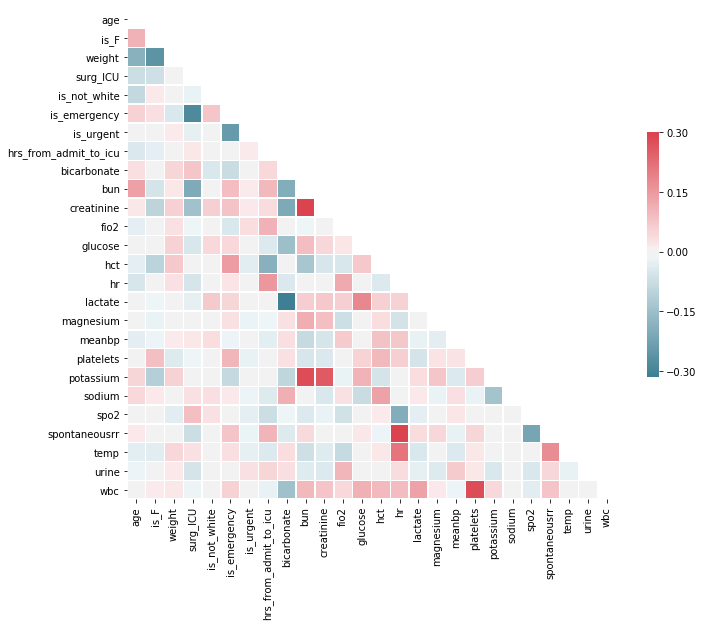

In [22]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [26]:
coverage = (corr.values > 0.1).astype(int)
coverage

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

In [ ]:
levels = {Age: 5,
          Bicarbonate: 2,
          Sodium: 2,
          Potassium:2,
          urine: 2,
          HR: 4}
len(levels)